In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [4]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [5]:
import torch
import matplotlib.pyplot as plt
from data_util import get_data_from_kaggle, restructure_date_information, get_static_df, one_label_scale_static_df, scale_stock_data
from constant import Constant
import pandas as pd
from torch import optim
from TFT import TFT_embedding, TFT, QuantilesLoss
from data import TFT_Dataset
from torch.utils.data import DataLoader ,random_split
from data_util import get_feature_length

c:\Users\Luan\Documents\DL\TFT\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [7]:
TFT

TFT.tft.TFT

In [8]:
constant = Constant()
constant

In [9]:
market = 'sp500' # [forbes2000, nasdaq, nyse, sp500]
year = '2017'

In [9]:
# stock = get_data_from_kaggle(market = 'sp500', start_date = f'01-01-{year}')
# generating static df can take a while because there is a rate limit with yfinance api
# static = get_static_df(stock,  constant.static_variables)

# stock.to_csv(f'dataset/sp500_{year}.csv', index=False)
# static.to_csv(f"dataset/sp500_{year}_static.csv")

In [17]:
stock = pd.read_csv(f'dataset/sp500_{year}.csv')
static = pd.read_csv(f"dataset/sp500_{year}_static.csv", index_col=0)

In [18]:
stock

,Date,Low,Open,Volume,High,Close,Adjusted Close,Stock Name
0,2017-01-03,45.740002,45.930000,1739600.0,46.750000,46.490002,44.433620,A
1,2017-01-04,46.820000,46.930000,1821300.0,47.380001,47.099998,45.016628,A
2,2017-01-05,46.360001,47.049999,1503700.0,47.070000,46.540001,44.481392,A
3,2017-01-06,46.560001,46.630001,2883400.0,48.070000,47.990002,45.867260,A
4,2017-01-09,47.910000,48.009998,2575300.0,48.560001,48.139999,46.010628,A
...,...,...,...,...,...,...,...,...
605210,2022-12-06,152.089996,154.220001,1964800.0,155.500000,153.050003,153.050003,ZTS
605211,2022-12-07,149.380005,152.960007,2444100.0,153.789993,150.250000,150.250000,ZTS
605212,2022-12-08,149.199997,150.529999,2267500.0,154.350006,153.679993,153.679993,ZTS
605213,2022-12-09,152.740005,153.940002,3274900.0,156.330002,153.389999,153.389999,ZTS


In [19]:
static

,industry,sector,country,beta,marketCap,bookValue,dividendRate,dividendYield,fiveYearAvgDividendYield,debtToEquity
A,Diagnostics & Research,Healthcare,United States,1.072,39891210240,20.530,0.99,0.0074,0.66,52.787
AAL,Airlines,Industrials,United States,1.399,9680030720,-7.387,0.00,0.0000,1.27,0.000
AAP,Specialty Retail,Consumer Cyclical,United States,1.194,2744477440,42.340,1.00,0.0243,2.44,171.801
AAPL,Consumer Electronics,Technology,United States,1.240,3622499778560,3.767,1.00,0.0042,0.62,209.059
ABBV,Drug Manufacturers - General,Healthcare,United States,0.613,322113306624,3.413,6.56,0.0359,4.13,1174.815
...,...,...,...,...,...,...,...,...,...,...
XYL,Specialty Industrial Machinery,Industrials,United States,1.050,30846726144,43.593,1.44,0.0114,1.16,19.840
YUM,Restaurants,Consumer Cyclical,United States,1.095,38885851136,-27.407,2.68,0.0193,1.81,0.000
ZBH,Medical Devices,Healthcare,United States,1.021,21979760640,61.997,0.96,0.0086,0.75,53.611
ZION,Banks - Regional,Financial Services,United States,1.060,8874271744,40.251,1.72,0.0284,3.47,0.000


In [20]:
static.loc["AAPL"].values

array(['Consumer Electronics', 'Technology', 'United States',
       np.float64(1.24), np.int64(3622499778560), np.float64(3.767),
       np.float64(1.0), np.float64(0.0042), np.float64(0.62),
       np.float64(209.059)], dtype=object)

In [21]:
valid_tickers = static.index
stock = stock[stock['Stock Name'].isin(valid_tickers)]

In [22]:
stock = stock.dropna()

In [23]:
stock_scaled, stock_scalar = scale_stock_data(stock, constant.columns_to_scale)
stock_scaled 

,Date,Low,Open,Volume,High,Close,Adjusted Close,Stock Name
0,2017-01-03,0.000000,0.000000,0.108231,0.000000,0.000000,0.000000,A
1,2017-01-04,0.008217,0.007499,0.113930,0.004743,0.004594,0.004368,A
2,2017-01-05,0.004717,0.008399,0.091776,0.002409,0.000377,0.000358,A
3,2017-01-06,0.006239,0.005249,0.188017,0.009938,0.011296,0.010740,A
4,2017-01-09,0.016511,0.015598,0.166526,0.013627,0.012426,0.011814,A
...,...,...,...,...,...,...,...,...
605210,2022-12-06,0.518709,0.522872,0.132240,0.522823,0.516862,0.526255,ZTS
605211,2022-12-07,0.504664,0.516396,0.170338,0.514121,0.502468,0.511865,ZTS
605212,2022-12-08,0.503731,0.503906,0.156301,0.516971,0.520101,0.529492,ZTS
605213,2022-12-09,0.522077,0.521433,0.236376,0.527047,0.518610,0.528002,ZTS


In [24]:
processed_df = restructure_date_information(stock_scaled)
processed_df

,Low,Open,Volume,High,Close,Adjusted Close,Stock Name,Month,Day,Day of The Week,Week of The Year
0,0.000000,0.000000,0.108231,0.000000,0.000000,0.000000,A,0,2,1,0
1,0.008217,0.007499,0.113930,0.004743,0.004594,0.004368,A,0,3,2,0
2,0.004717,0.008399,0.091776,0.002409,0.000377,0.000358,A,0,4,3,0
3,0.006239,0.005249,0.188017,0.009938,0.011296,0.010740,A,0,5,4,0
4,0.016511,0.015598,0.166526,0.013627,0.012426,0.011814,A,0,8,0,1
...,...,...,...,...,...,...,...,...,...,...,...
605210,0.518709,0.522872,0.132240,0.522823,0.516862,0.526255,ZTS,11,5,1,48
605211,0.504664,0.516396,0.170338,0.514121,0.502468,0.511865,ZTS,11,6,2,48
605212,0.503731,0.503906,0.156301,0.516971,0.520101,0.529492,ZTS,11,7,3,48
605213,0.522077,0.521433,0.236376,0.527047,0.518610,0.528002,ZTS,11,8,4,48


In [25]:
static_df = one_label_scale_static_df(static,constant.static_variables)

In [26]:
history_cat_feature_num_list, history_cont_feature_num = get_feature_length(processed_df, constant.feature_variables)
static_cat_feature_num_list , static_cont_feature_num  = get_feature_length(static, constant.static_variables)
future_cat_feature_num_list , _                        = get_feature_length(processed_df, constant.future_feature)
_                           , prediction_con           = get_feature_length(processed_df, constant.prediction_feature)

In [27]:
history_cat_feature_num_list, history_cont_feature_num


([12, 31, 5, 53], 4)

In [28]:
history_length = 90
prediction_length = 15
hidden_size = 128
batch_size = 128
dropout = .2
num_head = 4
lr= 0.0001
momentum=0.9
num_epochs = 10
max_grad_norm = 1
split_ratio = 0.8

In [29]:
tft_Dataset = TFT_Dataset(tft_df= processed_df , 
                        static_df=static_df,
                        autoformer_df=processed_df,
                        constant_variable=constant, 
                        history_length= history_length, 
                        tft_prediction_length= prediction_length, 
                        device = device)

In [30]:
train_size = int(0.8 * tft_Dataset.__len__())
test_size = len(tft_Dataset) - train_size

In [31]:
train_dataset, test_dataset = random_split(tft_Dataset, [train_size, test_size])

In [32]:
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [36]:
count =0
for static_cont_input, static_cat_input,history_cont_input, history_cat_input, future_input, prediction,_ ,_ in train_loader:
    break
print(static_cont_input.size(), static_cont_input.device)


torch.Size([128, 7]) cuda:0


In [37]:
model = TFT(static_cat_feature_num_list= static_cat_feature_num_list,
            static_cont_feature_num=static_cont_feature_num,
            history_cat_feature_num_list= history_cat_feature_num_list,
            history_cont_feature_num=history_cont_feature_num,
            future_cat_feature_num_list=future_cat_feature_num_list,
            history_len = history_length,
            future_len = prediction_length,
            dropout= dropout,
            num_head = num_head,
            hidden_size = hidden_size,
            device = device)
model.to(device)

TFT(
  (tft_embed): TFT_embedding(
    (static_cont): Linear(in_features=7, out_features=128, bias=True)
    (static_cat): ModuleList(
      (0): Embedding(108, 128)
      (1-2): 2 x Embedding(12, 128)
    )
    (history_cont): Linear(in_features=4, out_features=128, bias=True)
    (history_cat): ModuleList(
      (0): Embedding(12, 128)
      (1): Embedding(31, 128)
      (2): Embedding(5, 128)
      (3): Embedding(53, 128)
    )
    (future_feature): ModuleList(
      (0): Embedding(12, 128)
      (1): Embedding(31, 128)
      (2): Embedding(5, 128)
      (3): Embedding(53, 128)
    )
  )
  (cs): VariationSelection(
    (group_GRN): GRN(
      (linear1): Linear(in_features=512, out_features=512, bias=True)
      (linear2): Linear(in_features=512, out_features=128, bias=True)
      (GLU): GLU(
        (linear4): Linear(in_features=128, out_features=512, bias=True)
        (linear5): Linear(in_features=128, out_features=512, bias=True)
      )
      (droput): Dropout(p=0.0, inplace=Fal

In [38]:
loss_function = QuantilesLoss( device=device)
loss_function.to(device)
optimizer = optim.Adam(model.parameters(), lr = lr)

In [ ]:
model.train()
batch_loss = [] 
epoch_loss = []
for epoch in range(num_epochs):
    for i, (static_cont_input, static_cat_input,history_cont_input, history_cat_input, future_input, prediction) in enumerate(train_loader):
        predicted = model(static_cont_input, static_cat_input,history_cont_input, history_cat_input, future_input)
        optimizer.zero_grad()
        losses = loss_function(predicted = predicted, targets = prediction)
        loss = losses.sum()
        loss.backward()

        optimizer.step()
        if i % 1000 == 0:
            print(f'Epoch: {epoch+1}, Batch: {i},  Loss: {loss.item()}')
    batch_loss.append(loss.item())
    print("###########################")
    print(f'Epoch: {epoch+1},  Loss: {loss.item()}')
    epoch_loss.append(loss.item())

Epoch: 1, Batch: 0,  Loss: 0.7370415329933167
Epoch: 1, Batch: 1000,  Loss: 0.06530316919088364
Epoch: 1, Batch: 2000,  Loss: 0.05760008469223976
Epoch: 1, Batch: 3000,  Loss: 0.05004086717963219
###########################
Epoch: 1,  Loss: 0.0460890531539917
Epoch: 2, Batch: 0,  Loss: 0.046429745852947235
Epoch: 2, Batch: 1000,  Loss: 0.041177473962306976
Epoch: 2, Batch: 2000,  Loss: 0.04416148364543915
Epoch: 2, Batch: 3000,  Loss: 0.047361984848976135
###########################
Epoch: 2,  Loss: 0.03851417452096939
Epoch: 3, Batch: 0,  Loss: 0.040274303406476974
Epoch: 3, Batch: 1000,  Loss: 0.033386025577783585
Epoch: 3, Batch: 2000,  Loss: 0.039808087050914764
Epoch: 3, Batch: 3000,  Loss: 0.03599719703197479
###########################
Epoch: 3,  Loss: 0.03329778462648392
Epoch: 4, Batch: 0,  Loss: 0.03289635479450226
Epoch: 4, Batch: 1000,  Loss: 0.03345059975981712
Epoch: 4, Batch: 2000,  Loss: 0.03366268426179886
Epoch: 4, Batch: 3000,  Loss: 0.03143458813428879
#############

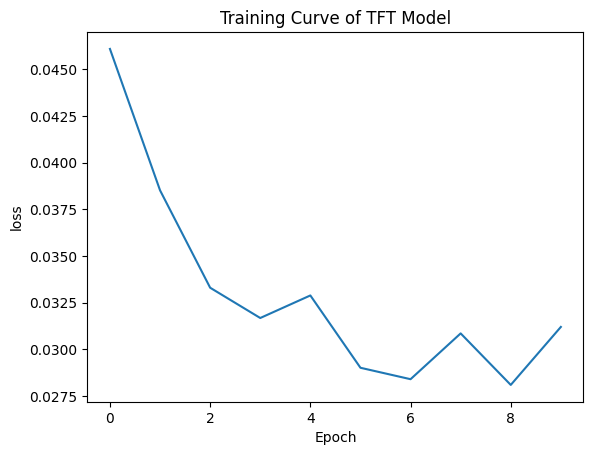

In [39]:
epoch_loss = [0.046089053153991, 0.03851417452096939, 0.03329778462648392,0.03167574852705002,0.03288362547755241,0.02900997921824455, 0.02839764580130577, 0.03085103631019592,0.028091154992580414,0.031197570264339447]

x = range(len(epoch_loss))
plt.plot(x,epoch_loss)
plt.title('Training Curve of TFT Model')
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.savefig('result/tft_training_curve.png')
plt.show()

In [ ]:
#torch.save(model.state_dict(), f"tft_model_{year}.pth")


In [41]:
model = TFT(static_cat_feature_num_list= static_cat_feature_num_list,
            static_cont_feature_num=static_cont_feature_num,
            history_cat_feature_num_list= history_cat_feature_num_list,
            history_cont_feature_num=history_cont_feature_num,
            future_cat_feature_num_list=future_cat_feature_num_list,
            history_len = history_length,
            future_len = prediction_length,
            dropout= dropout,
            num_head = num_head,
            hidden_size = hidden_size,
            device = device)


In [42]:
model.load_state_dict(torch.load(f'tft_model_{year}.pth', weights_only=True))
model.to(device)
model.eval()
count = 0
err = 0
with torch.no_grad():
    for i, (static_cont_input, static_cat_input,history_cont_input, history_cat_input, future_input, prediction,_,_) in enumerate(test_loader):
        predicted = model(static_cont_input, static_cat_input,history_cont_input, history_cat_input, future_input)

        diff = (prediction.squeeze(-1) - predicted[:,:,1])**2
        err += diff.sum()
        count += diff.size(0)

In [45]:
print('MSE of TFT on Test Data:' , (err/count).item())

MSE of TFT on Test Data: 0.07687681168317795
